In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import os
import sklearn
import sklearn.utils
from typing import List, Dict
from sklearn.metrics import roc_auc_score
import collections
import warnings
import random
import pickle
import femr.datasets
import datetime
import importlib.util
import sys
from hf_ehr.notebooks.ehr_specific_properties import utils
sns.set_context("paper")
sns.set_style('whitegrid', rc={
    'xtick.bottom': True,
    'ytick.left': True,
}) 
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

PATH_TO_DATABASE: str = '/share/pi/nigam/mwornow/ehrshot-benchmark/EHRSHOT_ASSETS/femr/extract'
PATH_TO_FEATURES_DIR: str = '/share/pi/nigam/mwornow/ehrshot-benchmark/EHRSHOT_ASSETS/features_ehrshot'
PATH_TO_RESULTS_DIR: str = '/share/pi/nigam/migufuen/ehrshot-benchmark/EHRSHOT_ASSETS/results_ehrshot'
PATH_TO_TOKENIZED_TIMELINES_DIR: str = '/share/pi/nigam/mwornow/ehrshot-benchmark/EHRSHOT_ASSETS/tokenized_timelines_ehrshot'
PATH_TO_LABELS_DIR: str = '/share/pi/nigam/mwornow/ehrshot-benchmark/EHRSHOT_ASSETS/benchmark_ehrshot'
PATH_TO_SPLIT_CSV: str = '/share/pi/nigam/mwornow/ehrshot-benchmark/EHRSHOT_ASSETS/splits_ehrshot/person_id_map.csv'
femr_db = femr.datasets.PatientDatabase(PATH_TO_DATABASE)
os.makedirs('../cache', exist_ok=True)

In [2]:
# Same ordering as paper
task_2_name: Dict[str, str] = {
    # Operational outcomes
    'guo_los': 'Long LOS',
    'guo_readmission': '30-Day Readmission',
    'guo_icu': 'ICU Admission',
    # Anticipating lab test results
    'lab_thrombocytopenia': 'Thrombocytopenia',
    'lab_hyperkalemia': 'Hyperkalemia',
    'lab_hypoglycemia': 'Hypoglycemia',
    'lab_hyponatremia': 'Hyponatremia',
    'lab_anemia': 'Anemia',
    # Assignment of new diagnoses
    'new_hypertension': 'Hypertension',
    'new_hyperlipidemia': 'Hyperlipidemia',
    'new_pancan': 'Pancreatic Cancer',
    'new_celiac': 'Celiac',
    'new_lupus': 'Lupus',
    'new_acutemi' : 'Acute MI',
    # Anticipating chest x-ray findings
    'chexpert' : 'Chest X-Ray',
}

task_2_value_type: Dict[str, str] = {
    'new_pancan': 'boolean',
    'new_celiac': 'boolean',
    'new_lupus': 'boolean',
    'new_acutemi' : 'boolean',
    'new_hypertension': 'boolean',
    'new_hyperlipidemia': 'boolean',
    'guo_los': 'boolean',
    'guo_readmission': 'boolean',
    'guo_icu': 'boolean',
    'lab_thrombocytopenia': 'multiclass',
    'lab_hyperkalemia': 'multiclass',
    'lab_hypoglycemia': 'multiclass',
    'lab_hyponatremia': 'multiclass',
    'lab_anemia': 'multiclass',
    'chexpert' : 'multilabel',
}

# Raw EHRSHOT label/patient counts per split

In [3]:
results = {
    'train' : [],
    'test' : [],
    'val' : [],
    'all' : []
}
df_split = pd.read_csv(PATH_TO_SPLIT_CSV)

for task, task_name in tqdm(task_2_name.items()):
    path_to_task_csv: str = os.path.join(PATH_TO_LABELS_DIR, task, "labeled_patients.csv")
    if not os.path.exists(path_to_task_csv):
        print(f"Skipping {task_name} @ {path_to_task_csv}")
        continue
    df = pd.read_csv(path_to_task_csv)
    value_type = task_2_value_type[task]
    if task_2_value_type[task] == "boolean":
        df['is_positive_label'] = df["value"]
    elif task_2_value_type[task] == "multiclass":
        df['is_positive_label'] = df["value"] > 0
    elif task_2_value_type[task] == "multilabel":
        df['is_positive_label'] = df["value"] != 8192
    else:
        print(f"Skipping {task_name}")
        continue
    
    # Splits
    for split in ['train', 'test', 'val']:
        df_ = df[df['patient_id'].isin(df_split[df_split['split'] == split]['omop_person_id'])]
        results[split].append({
            'task' : task,
            'task_name' : task_name,
            'n_patients' : df_['patient_id'].nunique(),
            'n_positive_patients' : df_.groupby('patient_id')['is_positive_label'].max().sum(),
            'n_labels' : df_.shape[0],
            'n_positive_labels' : df_['is_positive_label'].sum(),
        })
    
    # All
    results['all'].append({
        'task' : task,
        'task_name' : task_name,
        'n_patients' : df['patient_id'].nunique(),
        'n_positive_patients' : df.groupby('patient_id')['is_positive_label'].max().sum(),
        'n_labels' : df.shape[0],
        'n_positive_labels' : df['is_positive_label'].sum(),
    })

for key in results.keys():
    results[key] = pd.DataFrame(results[key])
    results[key]['n_negative_labels'] = results[key]['n_labels'] - results[key]['n_positive_labels']
    results[key]['n_negative_patients'] = results[key]['n_patients'] - results[key]['n_positive_patients']
    results[key]['label_prevalence'] = results[key]['n_positive_labels'] / results[key]['n_labels']
    results[key] = results[key][['task_name', 'n_patients', 'n_positive_patients', 'n_negative_patients', 'n_labels', 'n_positive_labels', 'n_negative_labels', 'label_prevalence']]

100%|██████████| 15/15 [00:34<00:00,  2.28s/it]


### Test

In [4]:
results['train']

,task_name,n_patients,n_positive_patients,n_negative_patients,n_labels,n_positive_labels,n_negative_labels,label_prevalence
0,Long LOS,1377,464,913,2569,681,1888,0.265084
1,30-Day Readmission,1337,164,1173,2608,370,2238,0.141871
2,ICU Admission,1306,107,1199,2402,113,2289,0.047044
3,Thrombocytopenia,2084,906,1178,68776,22714,46062,0.330261
4,Hyperkalemia,2038,456,1582,76349,1829,74520,0.023956
5,Hypoglycemia,2054,511,1543,122108,1904,120204,0.015593
6,Hyponatremia,2035,1294,741,81336,23877,57459,0.293560
7,Anemia,2092,1484,608,70501,49028,21473,0.695423
8,Hypertension,792,129,663,1259,182,1077,0.144559
9,Hyperlipidemia,923,137,786,1684,205,1479,0.121734


In [6]:
results['val']

,task_name,n_patients,n_positive_patients,n_negative_patients,n_labels,n_positive_labels,n_negative_labels,label_prevalence
0,Long LOS,1240,395,845,2231,534,1697,0.239355
1,30-Day Readmission,1191,159,1032,2206,281,1925,0.127380
2,ICU Admission,1157,84,1073,2052,92,1960,0.044834
3,Thrombocytopenia,1981,807,1174,54504,17867,36637,0.327811
4,Hyperkalemia,1935,428,1507,60168,1386,58782,0.023036
5,Hypoglycemia,1950,433,1517,95488,1449,94039,0.015175
6,Hyponatremia,1930,1174,756,64473,17557,46916,0.272316
7,Anemia,1992,1379,613,56224,38498,17726,0.684725
8,Hypertension,781,128,653,1247,175,1072,0.140337
9,Hyperlipidemia,863,140,723,1441,189,1252,0.131159


In [5]:
results['test']

,task_name,n_patients,n_positive_patients,n_negative_patients,n_labels,n_positive_labels,n_negative_labels,label_prevalence
0,Long LOS,1238,412,826,2195,552,1643,0.251481
1,30-Day Readmission,1190,151,1039,2189,260,1929,0.118776
2,ICU Admission,1154,75,1079,2037,85,1952,0.041728
3,Thrombocytopenia,1998,853,1145,56338,19137,37201,0.339682
4,Hyperkalemia,1958,405,1553,63653,1554,62099,0.024414
5,Hypoglycemia,1970,435,1535,100568,1368,99200,0.013603
6,Hyponatremia,1956,1224,732,67028,19274,47754,0.287551
7,Anemia,2002,1408,594,58155,39970,18185,0.687301
8,Hypertension,755,129,626,1258,159,1099,0.126391
9,Hyperlipidemia,864,133,731,1317,172,1145,0.130600


# Token / Timeline Length per Task

Calculate the distribution of patient-level timeline / token lengths per task.

In [7]:
# Get list of tasks
valid_tasks = os.listdir(PATH_TO_RESULTS_DIR)

# Load patient-level labels for each task
for task in tqdm(valid_tasks):
    if os.path.exists(f'../cache/ehrshot_stats/{task}.pkl'):
        print(f"Skipping {task} b/c cache .pkl already exists")
        continue

    label_data = []
    # Load labeled patients for this task
    PATH_TO_LABELED_PATIENTS: str =  os.path.join(PATH_TO_LABELS_DIR, task, 'labeled_patients.csv')
    labeled_patients = femr.labelers.load_labeled_patients(PATH_TO_LABELED_PATIENTS)
    
    # Get features for patients
    model: str = 'mamba-tiny-16384--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last'
    # model: str = 'gpt2-base-512--clmbr_train-tokens-total_nonPAD-ckpt_val=2000000000-persist_chunk:last_embed:last'
    patient_ids, label_values, label_times, feature_matrixes = utils.get_labels_and_features(labeled_patients, 
                                                                                            PATH_TO_FEATURES_DIR, 
                                                                                            PATH_TO_TOKENIZED_TIMELINES_DIR,
                                                                                            models_to_keep=[model,])
    train_pids_idx, val_pids_idx, test_pids_idx = utils.get_patient_splits_by_idx(PATH_TO_SPLIT_CSV, patient_ids)
    # !!!!!!!!!
    # ! IMPORTANT: Do not reshuffle label_values, label_times, patient_ids by train_pids_idx, val_pids_idx, test_pids_idx (as is done in ehr_specific_properties/stratify.py)
    #   b/c we will later use these pids_idx lists to directly slice into these arrays, and this slicing relies on the original order to be accurate
    # !!!!!!!!!
    label_times = [ x.astype(datetime.datetime) for x in label_times ] # cast to Python datetime

    # Recast label values => binary
    if task_2_value_type[task] == "boolean":
        label_values = label_values
    elif task_2_value_type[task] == "multiclass":
        label_values = label_values > 0
    elif task_2_value_type[task] == "multilabel":
        label_values = label_values != 8192
    else:
        raise ValueError(f"Unknown value type {task_2_value_type[task]}")

    PAD_TOKEN_ID: int = 4

    for split, pids_idx in zip(['train', 'val', 'test'], [train_pids_idx, val_pids_idx, test_pids_idx]):
        positive_pids_idx = [ i for i in pids_idx if label_values[i] ]
        # Events per patient
        n_events_per_patient: List[int] = []
        n_unique_events_per_patient: List[int] = []
        n_events_per_positive_patient: List[int] = []
        n_unique_events_per_positive_patient: List[int] = []
        for pid_idx in tqdm(pids_idx, total=len(pids_idx), desc=f"{task} - {split}"):
            events: List[str] = [ e.code for e in femr_db[patient_ids[pid_idx]].events if e.start <= label_times[pid_idx] ]
            n_events_per_patient.append(len(events))
            n_unique_events_per_patient.append(len(set(events)))
            if pid_idx in positive_pids_idx:
                n_events_per_positive_patient.append(len(events))
                n_unique_events_per_positive_patient.append(len(set(events)))
        label_data.append({
            'task' : task,
            'split' : split,
            'n_patients' : len(np.unique(patient_ids[pids_idx])),
            'n_labels' : len(pids_idx),
            'n_positive_patients' : len(np.unique(patient_ids[positive_pids_idx])),
            'n_positive_labels' : len(positive_pids_idx),
            # All patients
            'n_events_per_patient' : n_events_per_patient,
            'n_unique_events_per_patient' : n_unique_events_per_patient,
            'n_tokens_per_patient' : (feature_matrixes[model]['timelines'][pids_idx,:] != PAD_TOKEN_ID).sum(axis=1),
            # 'n_unique_tokens_per_patient' : (feature_matrixes[model]['timelines'][pids_idx,:]).sum(axis=1),
            # Positive patients
            'n_events_per_positive_patient' : n_events_per_positive_patient,
            'n_unique_events_per_positive_patient' : n_unique_events_per_positive_patient,
            'n_tokens_per_positive_patient' : (feature_matrixes[model]['timelines'][positive_pids_idx,:] != PAD_TOKEN_ID).sum(axis=1),
            # 'n_unique_tokens_per_positive_patient' : [ len(set([ x for x in t if x != PAD_TOKEN_ID ])) for t in feature_matrixes[model]['timelines'][positive_pids_idx,:] ]
        })
        # Sanity checks
        results_split = results[split][results[split]['task_name'] == task_2_name[task]]
        assert label_data[-1]['n_patients'] == results_split['n_patients'].values[0], f"{label_data[-1]['n_patients']} != {results_split['n_patients'].values[0]}"
        assert label_data[-1]['n_positive_patients'] == results_split['n_positive_patients'].values[0], f"{label_data[-1]['n_positive_patients']} != {results_split['n_positive_patients'].values[0]}"
        assert label_data[-1]['n_labels'] == results_split['n_labels'].values[0], f"{label_data[-1]['n_labels']} != {results_split['n_labels'].values[0]}"
        assert label_data[-1]['n_positive_labels'] == results_split['n_positive_labels'].values[0], f"{label_data[-1]['n_positive_labels']} != {results_split['n_positive_labels'].values[0]}"
        assert (np.array(label_data[-1]['n_unique_events_per_patient']) <= np.array(label_data[-1]['n_events_per_patient'])).all()
        assert (np.array(label_data[-1]['n_unique_events_per_positive_patient']) <= np.array(label_data[-1]['n_events_per_positive_patient'])).all()
        # assert (np.array(label_data[-1]['n_unique_tokens_per_patient']) <= np.array(label_data[-1]['n_tokens_per_patient'])).all()
        # assert (np.array(label_data[-1]['n_unique_tokens_per_positive_patient']) <= np.array(label_data[-1]['n_tokens_per_positive_patient'])).all()
        assert (np.array(label_data[-1]['n_tokens_per_patient']) <= np.array(label_data[-1]['n_events_per_patient'])).all()
        assert np.array(label_data[-1]['n_tokens_per_patient']).shape[0] == len(pids_idx)
        assert np.array(label_data[-1]['n_events_per_patient']).shape[0] == len(pids_idx)
        assert np.array(label_data[-1]['n_tokens_per_positive_patient']).shape[0] == len(positive_pids_idx)
        assert np.array(label_data[-1]['n_events_per_positive_patient']).shape[0] == len(positive_pids_idx)
    
    with open(f'../cache/ehrshot_stats/{task}.pkl', 'wb') as f:
        pickle.dump(label_data, f)

  7%|▋         | 1/15 [00:01<00:25,  1.80s/it]

Skipping new_hypertension b/c cache .pkl already exists


 33%|███▎      | 5/15 [00:04<00:07,  1.36it/s]

Skipping guo_los b/c cache .pkl already exists
Skipping lab_hypoglycemia b/c cache .pkl already exists
Skipping new_lupus b/c cache .pkl already exists
Skipping lab_hyponatremia b/c cache .pkl already exists
Skipping new_pancan b/c cache .pkl already exists


 47%|████▋     | 7/15 [00:05<00:04,  1.74it/s]

Skipping lab_anemia b/c cache .pkl already exists


 53%|█████▎    | 8/15 [00:08<00:07,  1.08s/it]

Skipping new_acutemi b/c cache .pkl already exists


 67%|██████▋   | 10/15 [00:10<00:04,  1.06it/s]

Skipping chexpert b/c cache .pkl already exists
Skipping guo_readmission b/c cache .pkl already exists


 73%|███████▎  | 11/15 [00:10<00:03,  1.15it/s]

Skipping lab_thrombocytopenia b/c cache .pkl already exists


 80%|████████  | 12/15 [00:12<00:03,  1.02s/it]

Skipping new_hyperlipidemia b/c cache .pkl already exists


 87%|████████▋ | 13/15 [00:13<00:02,  1.19s/it]

Skipping new_celiac b/c cache .pkl already exists


100%|██████████| 15/15 [00:16<00:00,  1.11s/it]

Skipping lab_hyperkalemia b/c cache .pkl already exists
Skipping guo_icu b/c cache .pkl already exists


In [8]:
df_labels = []
for task in valid_tasks:
    label_data = pickle.load(open(f'cache/ehrshot_stats/{task}.pkl', 'rb'))
    df_labels.append(pd.DataFrame(label_data))
df_labels = pd.concat(df_labels)
df_labels.head()

,task,split,n_patients,n_labels,n_positive_patients,n_positive_labels,n_events_per_patient,n_unique_events_per_patient,n_tokens_per_patient,n_events_per_positive_patient,n_unique_events_per_positive_patient,n_tokens_per_positive_patient
0,new_hypertension,train,792,1259,129,182,"[839, 5510, 451, 3242, 1073, 5671, 565, 778, 6...","[167, 439, 114, 241, 308, 384, 163, 194, 332, ...","[800, 5283, 421, 3177, 997, 5481, 528, 732, 59...","[5671, 565, 778, 7556, 14384, 15739, 20965, 32...","[384, 163, 194, 524, 1045, 1144, 1285, 258, 26...","[5481, 528, 732, 7325, 13580, 14893, 16384, 30..."
1,new_hypertension,val,781,1247,128,175,"[830, 3768, 2940, 6260, 12756, 546, 1815, 2970...","[216, 415, 237, 531, 719, 200, 362, 445, 474, ...","[790, 3680, 2895, 6104, 12489, 518, 1730, 2814...","[6260, 12756, 622, 943, 1898, 1648, 629, 1251,...","[531, 719, 194, 309, 331, 279, 189, 264, 247, ...","[6104, 12489, 594, 859, 1751, 1551, 609, 1179,..."
2,new_hypertension,test,755,1258,129,159,"[509, 214, 1995, 431, 417, 732, 313, 1518, 281...","[137, 79, 226, 120, 127, 210, 156, 336, 419, 4...","[480, 204, 1942, 409, 392, 690, 294, 1411, 261...","[431, 417, 5465, 248, 902, 3502, 7192, 4982, 4...","[120, 127, 457, 124, 174, 646, 622, 400, 526, ...","[409, 392, 5223, 225, 887, 3167, 6648, 4634, 4..."
0,guo_los,train,1377,2569,464,681,"[25, 4842, 5942, 2849, 247, 2511, 308, 567, 42...","[23, 279, 368, 311, 103, 202, 187, 224, 416, 7...","[23, 4782, 5832, 2697, 233, 2477, 274, 448, 38...","[25, 4842, 5942, 2849, 2511, 567, 4952, 6458, ...","[23, 279, 368, 311, 202, 224, 307, 365, 249, 3...","[23, 4782, 5832, 2697, 2477, 448, 4870, 6312, ..."
1,guo_los,val,1240,2231,395,534,"[313, 1233, 2720, 6038, 8926, 1509, 11685, 152...","[186, 331, 225, 338, 397, 349, 690, 119, 399, ...","[294, 1198, 2691, 5897, 8710, 1439, 11446, 148...","[1233, 1509, 152, 5777, 9868, 756, 7689, 893, ...","[331, 349, 119, 399, 370, 258, 575, 261, 182, ...","[1198, 1439, 148, 5694, 9714, 739, 7347, 850, ..."


In [27]:
def plot_cdf(df: pd.DataFrame, split: str, column: str, xlabel: str):
    df = df[df['split'] == split]
    fig, axes = plt.subplots(figsize=(10, 12), nrows=int(np.ceil(df.shape[0] / 3)), ncols=3)
    axes = axes.flatten()
    for idx, (_, row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
        counts, bin_edges = np.histogram(row[column], bins=100, density=True)
        cdf = np.cumsum(counts) * np.diff(bin_edges)  # Calculate CDF
        axes[idx].plot(bin_edges[1:], cdf)  # Plot the CDF as a line
        axes[idx].set_title(f"{task_2_name[row.task]}")
        axes[idx].set_xlabel(xlabel)
        axes[idx].set_ylabel("CDF")
        axes[idx].set_xscale('log')
    plt.suptitle(f"CDF of {xlabel} ({split} split)")
    plt.tight_layout()
    plt.show()

def plot_cdf_all(df: pd.DataFrame, split: str, column: str = 'events'):
    df = df[df['split'] == split]
    df = df[df['task'] != 'chexpert']
    fig, axes = plt.subplots(figsize=(10, 10), nrows=int(np.ceil(df.shape[0] / 3)), ncols=3)
    axes = axes.flatten()
    for idx, (_, row) in tqdm(enumerate(df.iterrows()), total=df.shape[0]):
        # Events per patient
        counts, bin_edges = np.histogram(row[f'n_{column}_per_patient'], bins=1000, density=True)
        cdf = np.cumsum(counts) * np.diff(bin_edges)
        axes[idx].plot(bin_edges[1:], cdf, label=f'All Labels (# of {column})')
        # Tokens per patient
        counts, bin_edges = np.histogram(row[f'n_{column}_per_positive_patient'], bins=1000, density=True)
        cdf = np.cumsum(counts) * np.diff(bin_edges)
        axes[idx].plot(bin_edges[1:], cdf, label=f'Positive Labels (# of {column})')
        axes[idx].set_title(f"{task_2_name[row.task]}", fontweight='bold')
        axes[idx].set_xlabel(f'# of {column}', fontsize=8)
        axes[idx].set_ylabel("CDF", fontsize=8)
        if column == 'events':
            axes[idx].set_xscale('log')

    # Hide the last unused subplot
    fig.delaxes(axes[-1])

    # Title
    plt.suptitle(f"EHRSHOT # of {column} per prediction ({split} split)")
    plt.tight_layout()

    # Legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
    plt.subplots_adjust(bottom=0.05)  # Adjust bottom to make space for the legend

    # Save
    os.makedirs('plots', exist_ok=True)
    fig.savefig(f'plots/ehrshot_{column}_cdf_{split}.png', bbox_inches='tight')

    plt.show()


### Plot All + Positive Only CDFs

  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 179.87it/s]


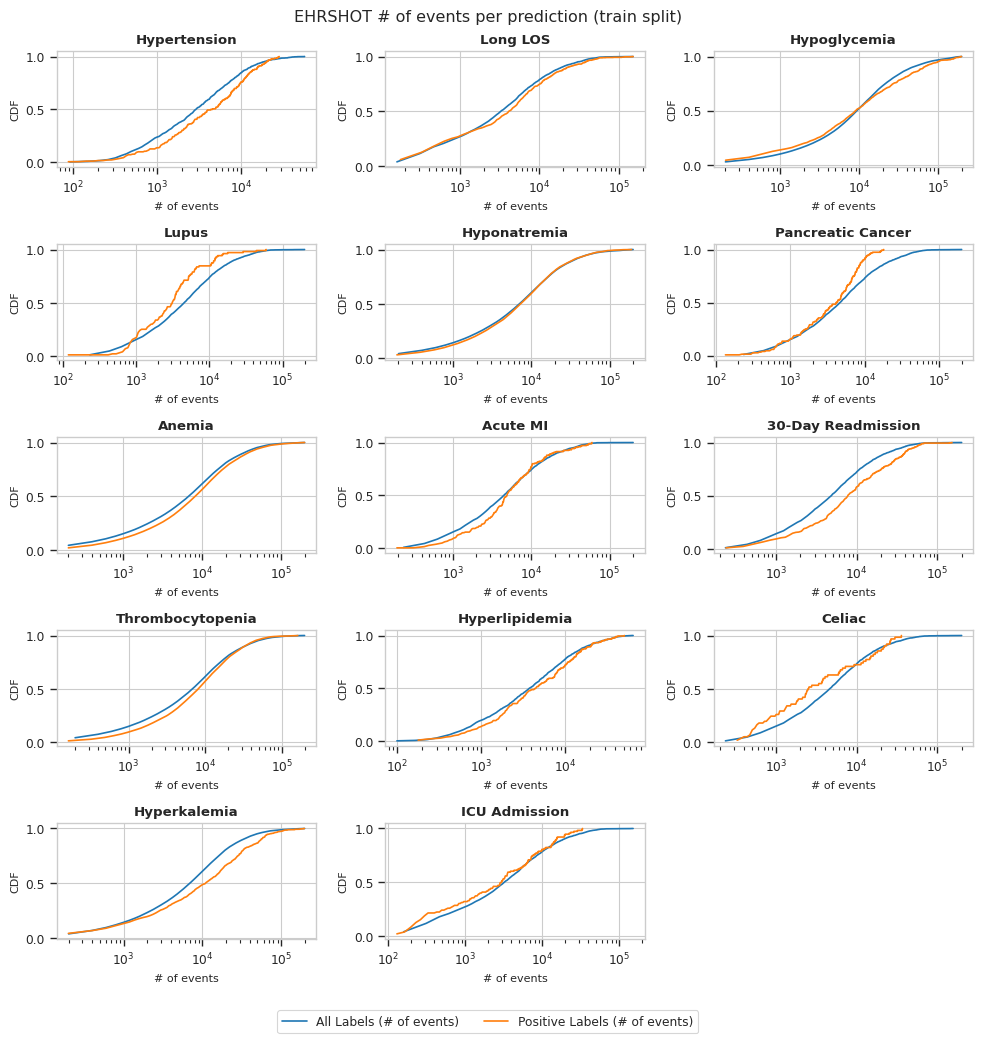

100%|██████████| 14/14 [00:00<00:00, 207.05it/s]


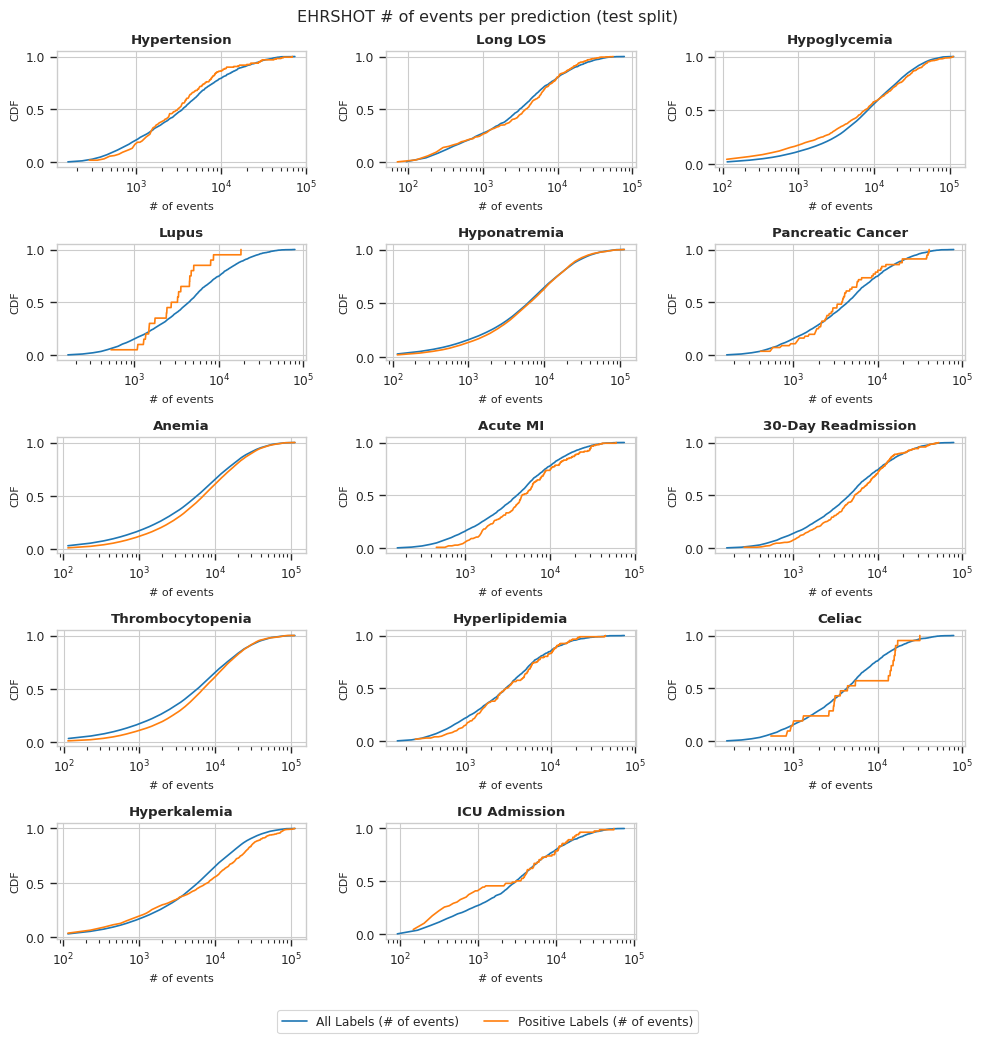

100%|██████████| 14/14 [00:00<00:00, 206.73it/s]


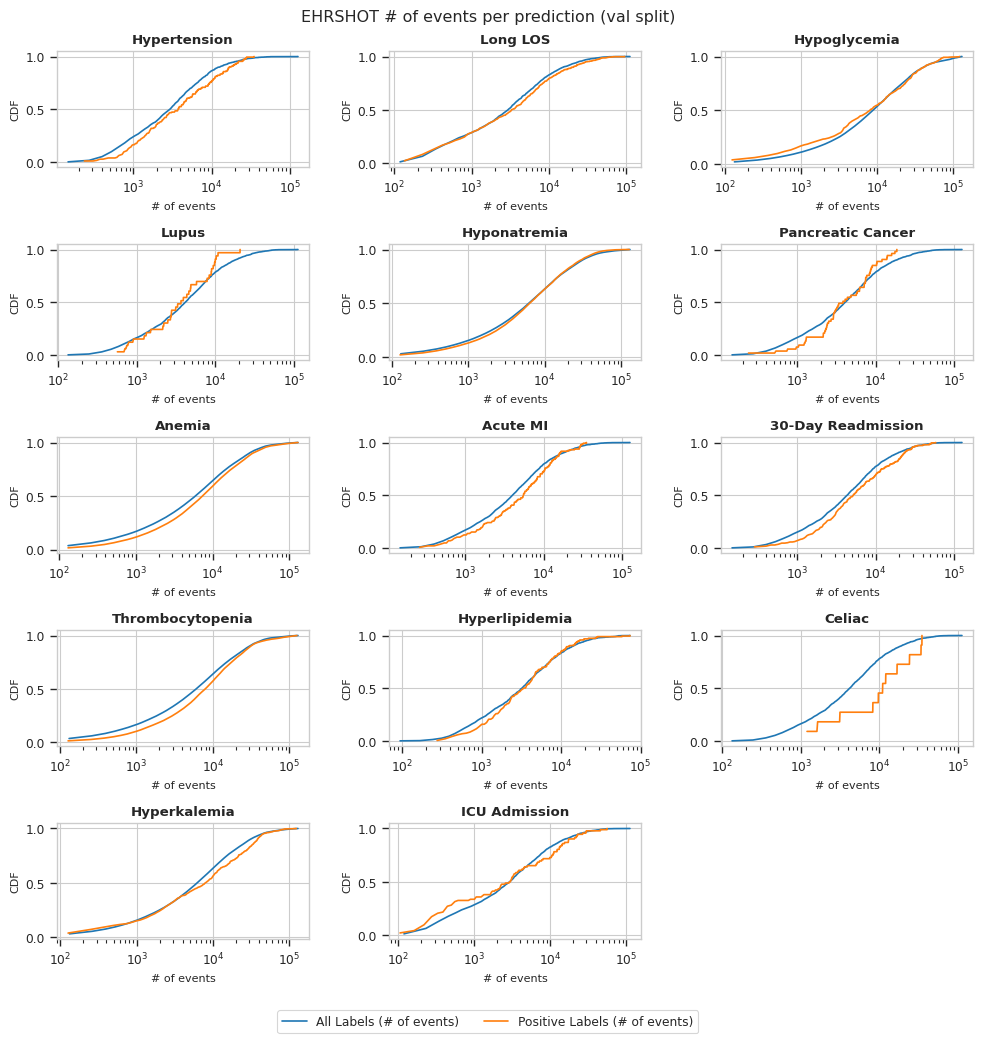

In [28]:
plot_cdf_all(df_labels, 'train', column='events')
plot_cdf_all(df_labels, 'test', column='events')
plot_cdf_all(df_labels, 'val', column='events')

100%|██████████| 14/14 [00:00<00:00, 386.12it/s]


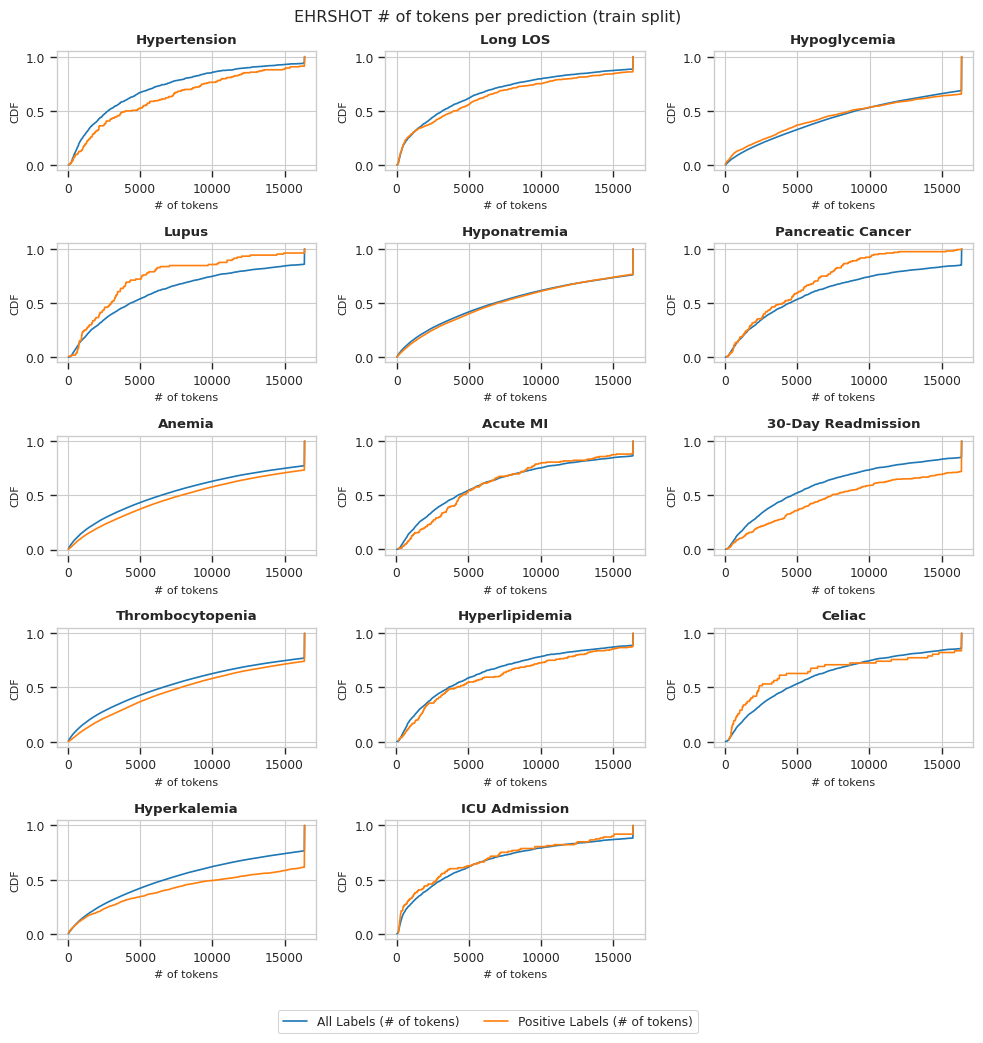

100%|██████████| 14/14 [00:00<00:00, 398.95it/s]


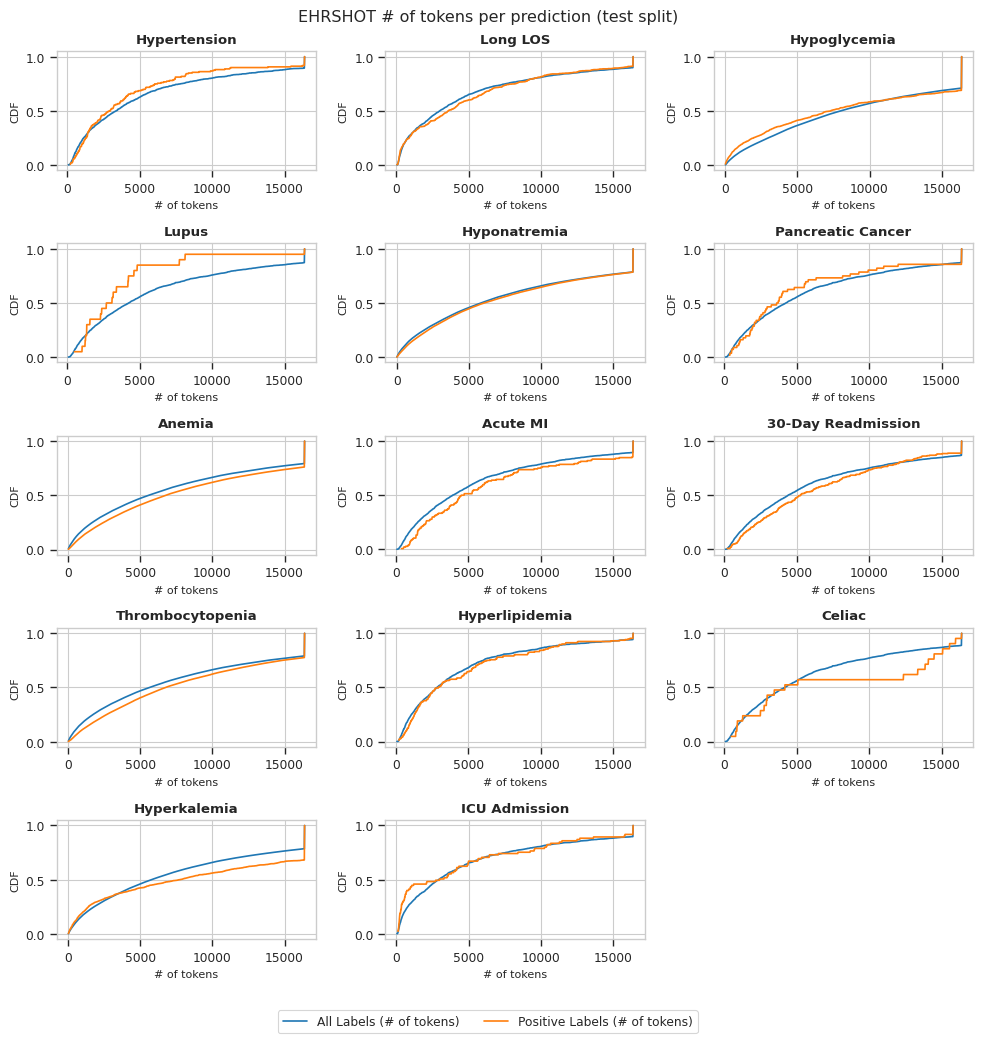

100%|██████████| 14/14 [00:00<00:00, 406.02it/s]


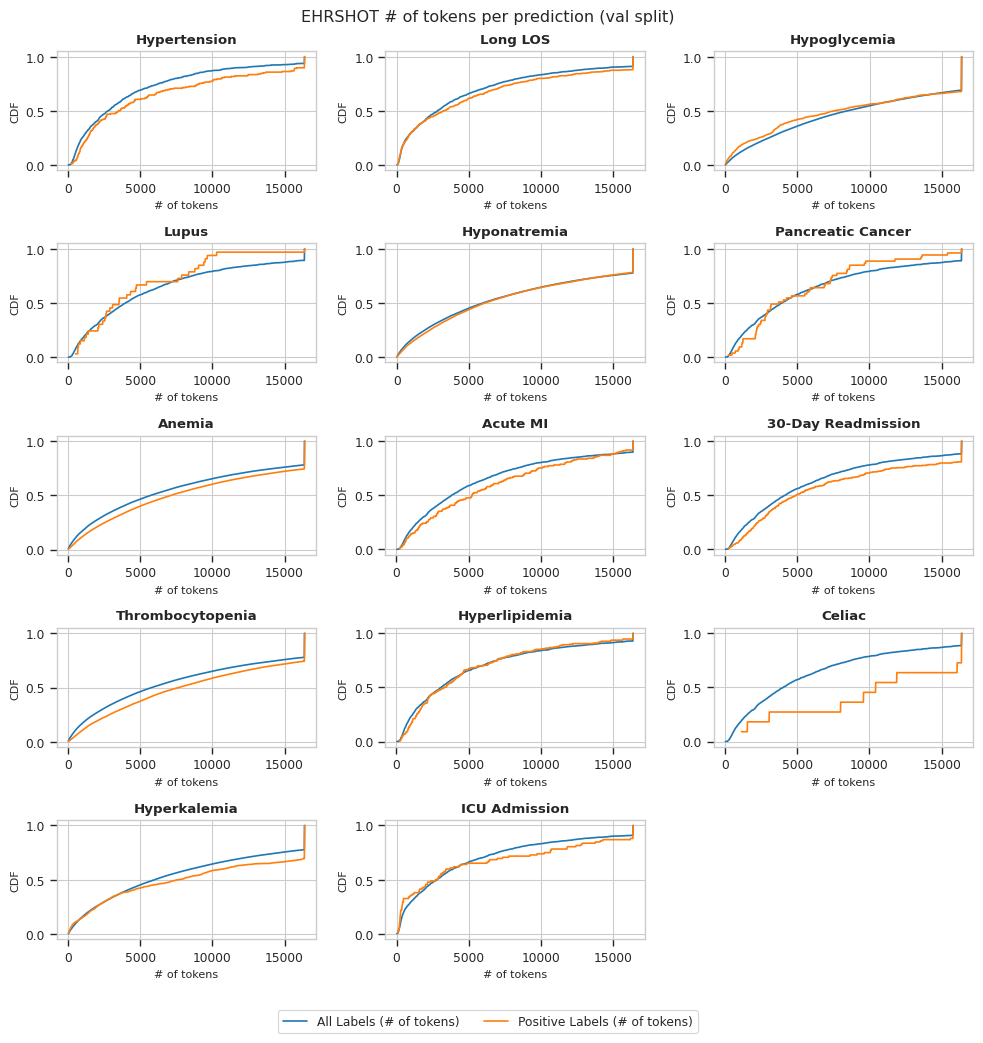

In [29]:
plot_cdf_all(df_labels, 'train', column='tokens')
plot_cdf_all(df_labels, 'test', column='tokens')
plot_cdf_all(df_labels, 'val', column='tokens')

### Plot Individual CDFs

In [ ]:
# plot_cdf(df_labels, 'train', 'n_events_per_patient', 'Events per Patient')
# plot_cdf(df_labels, 'val', 'n_events_per_patient', 'Events per Patient')
# plot_cdf(df_labels, 'test', 'n_events_per_patient', 'Events per Patient')
# plot_cdf(df_labels, 'train', 'n_tokens_per_patient', 'Tokens per Patient')
# plot_cdf(df_labels, 'val', 'n_tokens_per_patient', 'Tokens per Patient')
# plot_cdf(df_labels, 'test', 'n_tokens_per_patient', 'Tokens per Patient')